In [1]:
import os
# 2. DOWNLOAD THE DATASET
# Computer must have a unique kaggle.json file downloaded and have this path: "C:\Users\youruser\.kaggle\kaggle.json"
import kaggle

dataset_name = 'samithsachidanandan/human-face-emotions'
target_folder = 'human-face-emotions'

kaggle.api.dataset_download_files(dataset_name, path=target_folder, unzip=True)
print("Download complete!")

Dataset URL: https://www.kaggle.com/datasets/samithsachidanandan/human-face-emotions
Download complete!


In [ ]:
import tensorflow as tf
import os

data_dir = './human-face-emotions/data' 

# 2. Load the data
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    color_mode="grayscale",
    image_size=(48, 48),
    batch_size=32
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    color_mode="grayscale",
    image_size=(48, 48),
    batch_size=32
)

# 3. Verify it worked
print("Success! Classes found:", train_ds.class_names)

Found 59099 files belonging to 5 classes.
Using 47280 files for training.
Found 59099 files belonging to 5 classes.
Using 11819 files for validation.
Success! Classes found: ['Angry', 'Fear', 'Happy', 'Sad', 'Suprise']


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# 1. OPTIMIZE PERFORMANCE
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# 2. BUILD THE MODEL
num_classes = 5

model = models.Sequential([
    layers.Input(shape=(48, 48, 3)),
    layers.Rescaling(1./255),
    
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5), 
    
    # Softmax output
    layers.Dense(num_classes, activation='softmax') 
])

# 3. COMPILE (FIXED)
model.compile(optimizer='adam',
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            metrics=['accuracy'])

# 4. TRAIN
print("Starting training...")
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

# 5. SAVE
model.save('my_emotion_model.keras')
print("Model saved successfully!")

Starting training...
Epoch 1/10
1478/1478 ━━━━━━━━━━━━━━━━━━━━ 145s 52ms/step - accuracy: 0.4365 - loss: 1.3482 - val_accuracy: 0.5204 - val_loss: 1.1768
Epoch 2/10
1478/1478 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.5503 - loss: 1.1131 - val_accuracy: 0.5981 - val_loss: 1.0037
Epoch 3/10
1478/1478 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.5964 - loss: 1.0060 - val_accuracy: 0.6093 - val_loss: 0.9761
Epoch 4/10
1478/1478 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.6315 - loss: 0.9232 - val_accuracy: 0.6434 - val_loss: 0.8873
Epoch 5/10
1478/1478 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.6644 - loss: 0.8501 - val_accuracy: 0.6715 - val_loss: 0.8320
Epoch 6/10
1478/1478 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.6893 - loss: 0.7856 - val_accuracy: 0.6954 - val_loss: 0.7867
Epoch 7/10
1478/1478 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.7141 - loss: 0.7251 - val_accuracy: 0.7123 - val_loss: 0.7537
Epoch 8/10
1478/1478 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/ste

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


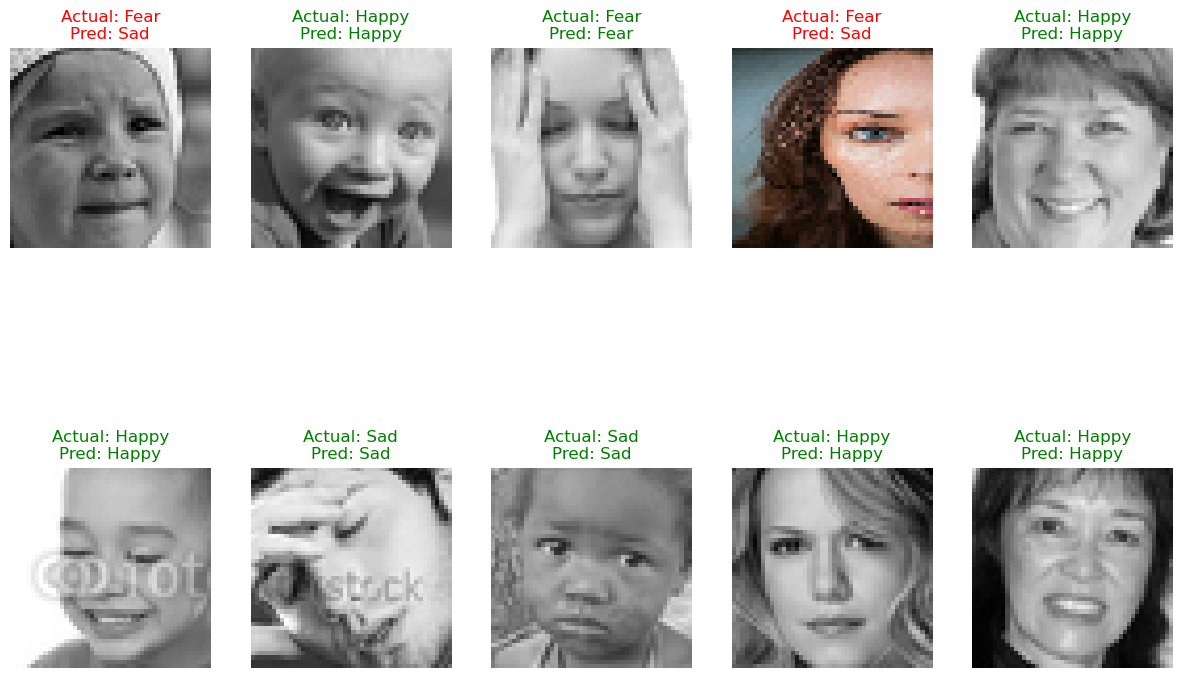

Computing Confusion Matrix


<Figure size 1000x800 with 0 Axes>

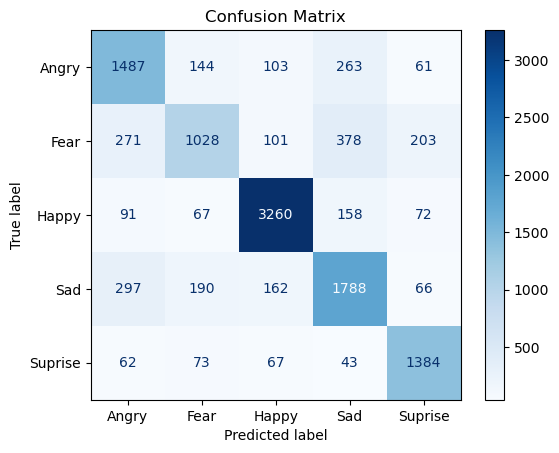

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ==========================================
# PART 1: VISUALIZE 10 PREDICTIONS
# ==========================================

# 1. Get a batch of images from the validation set
image_batch, label_batch = next(iter(val_ds))
class_names = ['Angry', 'Fear', 'Happy', 'Sad', 'Suprise']

# 2. Make predictions
predictions = model.predict(image_batch)
predicted_ids = np.argmax(predictions, axis=-1)

# 3. Plot 10 images
plt.figure(figsize=(15, 10))
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    
    actual_class = class_names[label_batch[i]]
    predicted_class = class_names[predicted_ids[i]]
    
    # Green title if correct, Red if wrong
    color = 'green' if actual_class == predicted_class else 'red'
    
    plt.title(f"Actual: {actual_class}\nPred: {predicted_class}", color=color)
    plt.axis("off")

plt.show()

# ==========================================
# PART 2: CONFUSION MATRIX
# ==========================================

print("Computing Confusion Matrix")

# Initialize lists to store all labels
all_labels = []
all_predictions = []

# Loop over the entire validation dataset to get true vs predicted
for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    predicted_ids = np.argmax(preds, axis=-1)
    
    all_labels.extend(labels.numpy())
    all_predictions.extend(predicted_ids)

# Generate the matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plot it
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()